In this notebook, we take a deeper look at how the transformer LLM works internally. We will use the 125M parameter [GPT2-small](https://huggingface.co/openai-community/gpt2) model.

GPT2-small models uses 768 dimensional token embeddings. We will feed the simple prompt "hi there",  corresponding to 2 tokens, to various model layers and observe the outputs. We will look at
* The token embedding layer: this layer transformer integer token ids to token embeddings.
* The positional embedding layer: this layers computes embeddings for token positions.
* The attention layer: this layer applies attention mechanism to input embeddings.
* The transform block: each transformer block has an attention layer and a feed forward layer, and transforms input embeddings with these sub layers.



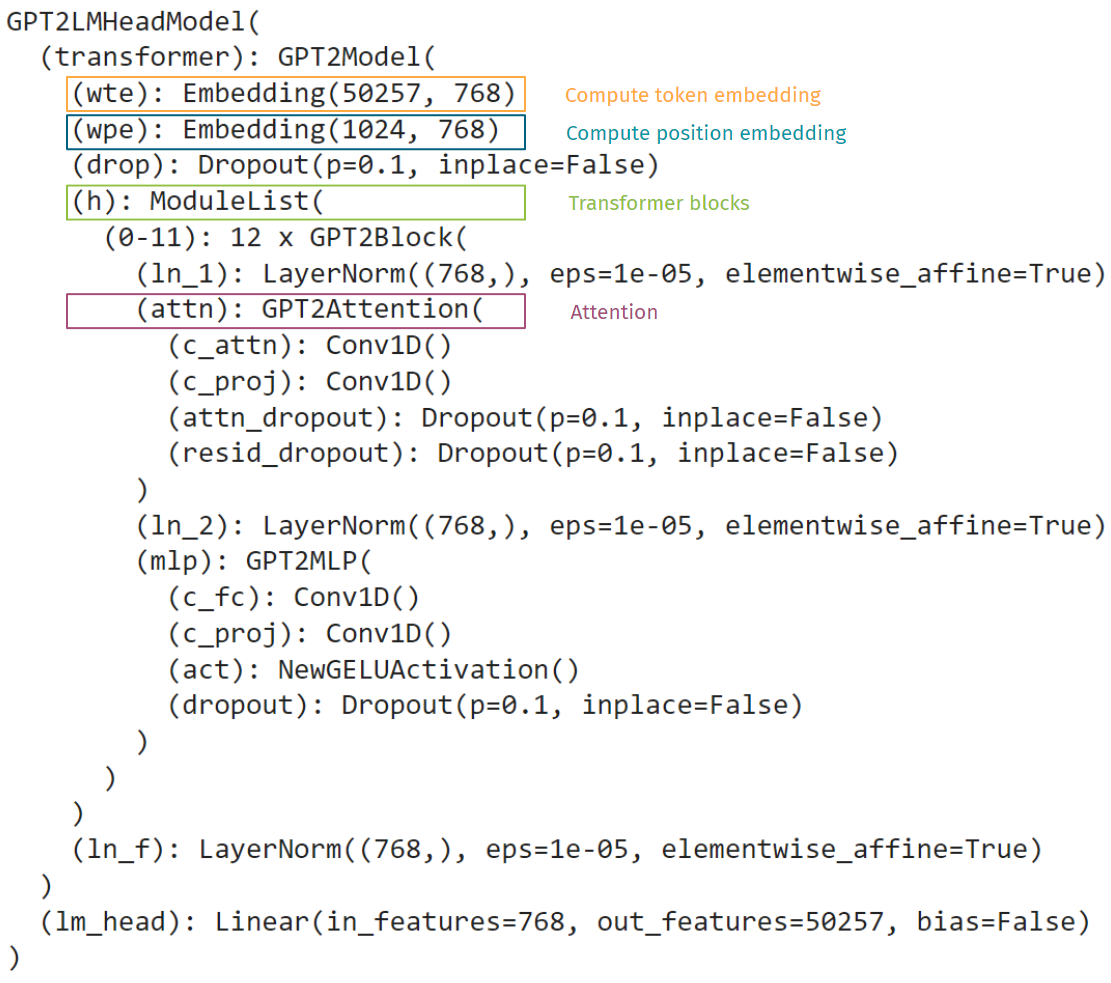



In [ ]:
#@title Obtain pretrained gpt2-small model,
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model =  GPT2LMHeadModel.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

We first tokenize a simple text string "hi there". This gives 2 integer token ids. Note in the tokenizer output, `input_ids` key holds the token ids.

The token id tensor we get has shape [1, 2], representing [batch_size, seq_len]. In deep learning frameworks, we often send multiple input examples to the model to increase GPU utilization and throughput, the number of input examples we send is called batch size. In this demo, we are only sending 1 input example (our "hi there" prompt), so our batch size will always be 1, and it will appear as the leading dimension of our computation result tensors.

In [ ]:
inputs = tokenizer("hi there", return_tensors="pt")
inputs

{'input_ids': tensor([[5303,  612]]), 'attention_mask': tensor([[1, 1]])}

In [ ]:
input_ids = inputs['input_ids']
input_ids

tensor([[5303,  612]])

In [ ]:
input_ids.shape

torch.Size([1, 2])

The token embedding layer `model.transformer.wte` takes integer token ids as input. For each token id, the embedding layer performs the token_id->embedding dictionary look up, and returns a 768 dimension embedding vector.

Our text input has 2 tokens. Therefore the embedding layer returns a matrix of shape [1, 2, 768], representing [batch_size, seq_len, embedding_dim].

In [ ]:
embeddings = model.transformer.wte(input_ids)
embeddings.shape

torch.Size([1, 2, 768])

The position encoding layer `model.transformer.wpe` takes integer token positions as input. For each position, the layer encodes it as a 768 dimension vector, matching the dimentionality of the token embedding vector.

Our text input has 2 tokens. Therefore the position encoding layer also returns a matrix of shape [1, 2, 768], representing [batch_size, seq_len, embedding_dim].

In [ ]:
positions = torch.tensor([0, 1])
position_embeddings = model.transformer.wpe(positions)
position_embeddings.shape

torch.Size([2, 768])

GPT2 model has 12 transformer blocks: `model.transformer.h[0]` through `model.transformer.h[11]`. Each transformer block contains an attention layer and a feed forward layer.

We use the attention layer from the first transformer block: `model.transformer.h[0].attn`. This attention layer receives as input the element wise sum of token embeddings and position encodings. The input has shape  [1, 2, 768], representing [batch_size, seq_len, embedding_dim].

The attention layer lets every token in the input attend to every other token, and generate transformed token embeddings as attention weighted sum of all input token embeddings. The transformed token embedding maintains its dimensionality. Therefore the attention layer also returns a matrix of shape [1, 2, 768], representing [batch_size, seq_len, embedding_dim].

In [ ]:
attention_output = model.transformer.h[0].attn(embeddings + position_embeddings)[0]
print(attention_output.shape)

torch.Size([1, 2, 768])


The very first transformer block `model.transformer.h[0]` takes as input the element wise sum of token embeddings and position encodings. The input has shape [1, 2, 768], representing [batch_size, seq_len, embedding_dim].

The transformer block transforms token embeddings while maintaining embedding dimensions. The block again returns a matrix of shape [1, 2, 768], compatible as the next transformer block's input.

In [ ]:
transformer_block_output = model.transformer.h[0](embeddings + position_embeddings)[0]
print(transformer_block_output.shape)

torch.Size([1, 2, 768])


Now let's look at the output when we pass input token ids through the entire GPT2-small model. We see that the output has shape [1, 2, 50257].

Where does the number 50257 come from? This is the size of GPT2-small's vocabulary. Recall that LLMs predicts next token probability for every single token in the vocabulary. This tensor, once normalized, will become 50257 probabilities.

In [ ]:
model_output = model(**inputs)
print(model_output.logits.shape)

torch.Size([1, 2, 50257])
